In [57]:
import pandas as pd

In [58]:
df=pd.read_csv('/content/DATA2025.csv',parse_dates=["Arrival_Date"], dayfirst=True)

In [59]:
df.duplicated().sum()

np.int64(0)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           4431 non-null   object        
 1   District        4431 non-null   object        
 2   Market          4431 non-null   object        
 3   Commodity       4431 non-null   object        
 4   Variety         4431 non-null   object        
 5   Grade           4431 non-null   object        
 6   Arrival_Date    4431 non-null   datetime64[ns]
 7   Min_Price       4431 non-null   float64       
 8   Max_Price       4431 non-null   int64         
 9   Modal_Price     4431 non-null   float64       
 10  Commodity_Code  4431 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 380.9+ KB


In [61]:
df.sort_values("Arrival_Date").tail()

,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_Price,Max_Price,Modal_Price,Commodity_Code
4426,Maharashtra,Nashik,Lasalgaon,Onion,Red,Local,2025-12-06,500.0,3700,2200.0,23
4427,Maharashtra,Nashik,Lasalgaon,Onion,Other,Local,2025-12-08,700.0,1731,1351.0,23
4428,Maharashtra,Nashik,Lasalgaon,Onion,Red,Local,2025-12-08,601.0,3600,2400.0,23
4429,Maharashtra,Nashik,Lasalgaon,Onion,Other,Local,2025-12-13,400.0,2016,1851.0,23
4430,Maharashtra,Nashik,Lasalgaon,Onion,Red,Local,2025-12-13,700.0,4101,2451.0,23


In [62]:
df['Market'].value_counts()

,count
Market,
Manmad,448
Pimpalgaon Baswant(Saykheda),359
Lasalgaon,307
Pimpalgaon,302
Lasalgaon(Vinchur),268
Lasalgaon(Niphad),266
Chandvad,241
Yeola,231
Nasik,229


In [63]:
df["Grade"].value_counts()

,count
Grade,
Local,3952
FAQ,479


In [64]:
df_lasalgaon=df[df["Market"]=="Lasalgaon"].copy()

In [65]:
mean_table=df_lasalgaon.groupby(['Grade','Variety'],as_index=False)["Modal_Price"].mean()

In [66]:
mean_table

,Grade,Variety,Modal_Price
0,FAQ,Red,2267.190476
1,Local,Other,1439.612903
2,Local,Red,1974.666667


In [67]:
df_lasalgaon["Grade"].value_counts()

,count
Grade,
Local,286
FAQ,21


In [68]:
df_lasalgaon["Grade"].value_counts()

,count
Grade,
Local,286
FAQ,21


In [69]:
df['Variety'].value_counts()

,count
Variety,
Other,3263
Red,972
Pole,155
White,41


In [70]:
df_lasalgaon["Arrival_Date"].value_counts().sort_values(ascending=False)

,count
Arrival_Date,
2025-03-03,2
2025-03-04,2
2025-03-05,2
2025-03-06,2
2025-03-10,2
...,...
2025-10-30,1
2025-10-28,1
2025-10-27,1


In [71]:
df2025_daily=df_lasalgaon.groupby("Arrival_Date")["Modal_Price"].median()

In [72]:
df2025_daily=df2025_daily.reset_index()

In [73]:
df2025_daily.tail(10)

,Arrival_Date,Modal_Price
237,2025-11-26,1640.0
238,2025-11-27,1590.0
239,2025-11-28,1425.5
240,2025-12-01,2100.0
241,2025-12-02,1850.0
242,2025-12-03,2112.5
243,2025-12-05,1950.0
244,2025-12-06,1850.0
245,2025-12-08,1875.5
246,2025-12-13,2151.0


In [74]:
import pickle
from datetime import timedelta
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib
import xgboost as xgb
import shap

In [75]:
RAINFALL_CSV = "RainfallData2025.csv"
FESTIVAL_CSV = "festival_dates_lasalgaon_onion_prices.csv"
GOVT_CSV = "onion_government_interventions_lasalgaon_2013_2025.csv"
MODEL_PATH = "xgb_final_all_data.model"
OUT_FEATURES = "2025_features.csv"
OUT_PRED = "2025_predictions.csv"

In [76]:
FEATURES = [
 'log_ret',
 'log_return_lag1',
 'vol_7',
 'vol_7_lag1',
 'vol_30',
 'vol_30_lag1',
 'rainfall_7d',
 'rainfall_7d_lag1',
 'festival_window',
 'days_since_last_arrival',
 'is_price_jump',
 'price_momentum_7',
 'price_momentum_3',
 'month_sin',
 'month_cos',
 'dow_sin',
 'dow_cos',
 'govt_window',
 'govt_none',
 'govt_buffer_operations',
 'govt_export_restriction',
 'govt_farmer_actions',
 'govt_import_support',
 'govt_market_intervention',
 'govt_procurement_support',
 'govt_stock_limit_actions'
]

In [77]:
def build_calendar(df_daily, start_date, end_date):
    cal = pd.DataFrame({"Arrival_Date": pd.date_range(start_date, end_date, freq="D")})
    cal = cal.merge(df_daily, on="Arrival_Date", how="left")
    return cal

In [78]:
def safe_impute_prices(calendar, max_gap=3):
    cal = calendar.copy()
    cal["Modal_Price_ffill"] = cal["Modal_Price"].ffill()
    cnt = 0; days=[]
    for _, r in cal.iterrows():
        if not pd.isna(r["Modal_Price"]):
            cnt = 0; days.append(0)
        else:
            cnt += 1; days.append(cnt)
    cal["days_from_last_obs"] = days
    cal["Modal_Price_imp"] = cal["Modal_Price_ffill"].where(cal["days_from_last_obs"] <= max_gap, np.nan)
    cal["Modal_Price"] = cal["Modal_Price"].combine_first(cal["Modal_Price_imp"])
    return cal

In [79]:
def compute_returns_vols(cal):
    cal = cal.copy()
    cal["log_ret"] = np.log(cal["Modal_Price"] / cal["Modal_Price"].shift(1)).fillna(0.0)
    cal["log_return_lag1"] = cal["log_ret"].shift(1).fillna(0.0)
    cal["vol_7"] = cal["log_ret"].rolling(window=7, min_periods=3).std().fillna(0.0)
    cal["vol_30"] = cal["log_ret"].rolling(window=30, min_periods=7).std().fillna(0.0)
    cal["vol_7_lag1"] = cal["vol_7"].shift(1).fillna(0.0)
    cal["vol_30_lag1"] = cal["vol_30"].shift(1).fillna(0.0)
    return cal

In [80]:
def compute_rainfall(cal, rainfall_df):
    rf = rainfall_df.copy()
    val_col = "precipitation_sum (mm)"

    rf["Date"]=pd.to_datetime(rf["Date"], dayfirst=True).dt.normalize()
    rain_map = rf.set_index("Date")[val_col].to_dict()
    cal["rain_mm"] = cal["Arrival_Date"].map(rain_map).fillna(0.0)
    cal["rainfall_7d"] = cal["rain_mm"].rolling(window=7, min_periods=1).sum().fillna(0.0)
    cal["rainfall_7d_lag1"] = cal["rainfall_7d"].shift(1).fillna(0.0)
    return cal

In [81]:
def add_calendar_features(cal):
    cal["month"] = cal["Arrival_Date"].dt.month
    cal["dow"] = cal["Arrival_Date"].dt.dayofweek
    # cyclic encodings
    cal["month_sin"] = np.sin(2*np.pi*(cal["month"]-1)/12)
    cal["month_cos"] = np.cos(2*np.pi*(cal["month"]-1)/12)
    cal["dow_sin"] = np.sin(2*np.pi*cal["dow"]/7)
    cal["dow_cos"] = np.cos(2*np.pi*cal["dow"]/7)
    return cal

In [82]:
def add_festival_window(cal, festival_df, window=2):
    fest = festival_df.copy()
    fest['festival_dates']=pd.to_datetime(fest['festival_dates'],dayfirst=True).dt.normalize()
    date_col = fest.columns[0]
    fest_set = set(fest[date_col])
    fest_days = set()
    for d in fest_set:
        for w in range(-window,window+1):
            fest_days.add((pd.Timestamp(d) + pd.Timedelta(days=w)).normalize())
    cal["festival_window"] = cal["Arrival_Date"].isin(fest_days).astype(int)
    return cal

In [83]:
def compute_days_since_last_arrival(cal):
    days = []
    last = None
    for _, r in cal.iterrows():
        if r["Modal_Price"]>0:
            last = r["Arrival_Date"]
            days.append(0)
        else:
            if last is None:
                days.append(1)
            else:
                days.append((r["Arrival_Date"] - last).days)
    cal["days_since_last_arrival"] = days
    cal["days_since_last_arrival"] = cal["days_since_last_arrival"].clip(0,10)
    return cal

In [84]:
def compute_price_jump_and_momentum(cal):
    cal["is_price_jump"] = (cal['log_ret'].abs()>2*cal['vol_30']).astype(int)
    # momentum: sum of log returns over window (or mean) — use rolling sum of log_ret
    cal["price_momentum_7"] = cal["log_ret"].rolling(window=7, min_periods=1).sum().fillna(0.0)
    cal["price_momentum_3"] = cal["log_ret"].rolling(window=3, min_periods=1).sum().fillna(0.0)
    return cal

In [85]:
GOVT_MAP = {
    "export restriction - mep": "govt_export_restriction",
    "export ban": "govt_export_restriction",
    "export policy": "govt_export_restriction",
    "buffer stock": "govt_buffer_operations",
    "buffer stock release": "govt_buffer_operations",
    "stock limit": "govt_stock_limit_actions",
    "stock limit revision": "govt_stock_limit_actions",
    "import facilitation": "govt_import_support",
    "import action": "govt_import_support",
    "market intervention": "govt_market_intervention",
    "market monitoring": "govt_market_intervention",
    "market relief": "govt_market_intervention",
    "market development": "govt_market_intervention",
    "retail sales intervention": "govt_market_intervention",
    "procurement request": "govt_procurement_support",
    "procurement support": "govt_procurement_support",
    "state relief": "govt_procurement_support",
    "policy liberalization": "govt_procurement_support",
    "farmer action": "govt_farmer_actions",
    "farmer protest": "govt_farmer_actions",
    "export duty": "govt_export_restriction",
    "export ban extension": "govt_export_restriction",
}

In [86]:
def process_govt_interventions(govt_df, window=3):
    g = govt_df.copy()
    g["Date"] = pd.to_datetime(g["Date"], dayfirst=True).dt.normalize()
    g["Category"] = g["Category"].astype(str).str.lower().str.strip()


    gov_map = {}
    for idx, row in g.iterrows():
        d = row["Date"]
        cat = row["Category"]
        mapped = None
        for key in GOVT_MAP:
            if key in cat:
                mapped = GOVT_MAP[key]
                break
        if mapped is None:
            continue
        for w in range(-window, window+1):
            dt = (d + pd.Timedelta(days=w)).normalize()
            if dt not in gov_map:
                gov_map[dt] = set()
            gov_map[dt].add(mapped)
    return gov_map

In [87]:
def add_govt_flags(cal, gov_map):
    cal = cal.copy()
    cal["Arrival_Date"] = pd.to_datetime(cal["Arrival_Date"]).dt.normalize()

    gov_cols = [c for c in FEATURES if c.startswith("govt_")]
    for c in gov_cols:
        if c not in cal.columns:
            cal[c] = 0

    for i, r in cal.iterrows():
        d = r["Arrival_Date"]
        if d in gov_map:
            flags = gov_map[d]
            cal.at[i, "govt_window"] = 1
            for f in flags:
                if f in cal.columns:
                    cal.at[i, f] = 1
    return cal

In [88]:
def cvi_score_from_proba(proba):
    p = np.array(proba)
    return float(p[1]*50 + p[2]*100)

def cvi_label_from_score(score):
    if score < 28.478758096694946:
      return "Low"
    elif score < 71.50789070129395:
      return "Medium"
    else:
      return "High"

In [89]:
def predict_proba(model, X):
    Xf = X.fillna(0.0)
    dmat = xgb.DMatrix(Xf.values, feature_names=Xf.columns.tolist())
    out=model.predict(dmat)
    return out

In [90]:
# Multi-step forecast (recursive), uses last row to simulate next days
def make_feature_row(base_df, predict_date, rainfall_map, festival_set):
    last = base_df.iloc[-1]
    feat = {}

    # assume zero mean return
    new_log_ret = 0.0

    # EWMA-style volatility update
    lambda_ = 0.94  # standard
    prev_var = last.get("vol_7", 0.0) ** 2
    new_var = lambda_ * prev_var + (1 - lambda_) * (new_log_ret ** 2)
    new_vol_7 = np.sqrt(new_var)

    feat["log_ret"] = new_log_ret
    feat["log_return_lag1"] = last.get("log_ret", 0.0)

    feat["vol_7"] = new_vol_7
    feat["vol_7_lag1"] = last.get("vol_7", 0.0)

    # slow volatility reverts
    feat["vol_30"] = 0.9 * last.get("vol_30", 0.0) + 0.1 * new_vol_7
    feat["vol_30_lag1"] = last.get("vol_30", 0.0)
    feat["Modal_Price"] = last.get("Modal_Price", 0.0)
    feat["rainfall_7d"] = last.get("rainfall_7d", 0.0)
    feat["rainfall_7d_lag1"] = last.get("rainfall_7d_lag1", 0.0)
    feat["festival_window"] = 1 if predict_date in festival_set else 0
    feat["days_since_last_arrival"] = last.get("days_since_last_arrival", 0) + 1
    feat["is_price_jump"] = 0
    feat["price_momentum_7"] = 0.9 * last.get("price_momentum_7", 0.0)
    feat["price_momentum_3"] = 0.9 * last.get("price_momentum_3", 0.0)
    # cyclic features for date
    m = predict_date.month;
    dow = predict_date.dayofweek
    feat["month_sin"] = np.sin(2*np.pi*(m-1)/12)
    feat["month_cos"] = np.cos(2*np.pi*(m-1)/12)
    feat["dow_sin"] = np.sin(2*np.pi*dow/7)
    feat["dow_cos"] = np.cos(2*np.pi*dow/7)

    for c in FEATURES:
        if c.startswith("govt_"):
            feat[c] = 0

    row = pd.DataFrame([feat])[FEATURES].fillna(0.0)
    return row, feat

In [91]:
def multi_step_cvi(base_df, model, n_steps=[1, 3, 7], rainfall_map=None, festival_set=set()):

    base = deepcopy(base_df.sort_values("Arrival_Date").reset_index(drop=True))

    results = {}
    max_h = max(n_steps)

    last_date = base["Arrival_Date"].max()

    for h in range(1, max_h + 1):
        predict_date = last_date + timedelta(days=h)
        Xrow, featdict = make_feature_row(
            base,
            predict_date,
            rainfall_map,
            festival_set
        )

        proba = predict_proba(model, Xrow)[0].tolist()
        score = cvi_score_from_proba(proba)
        label = cvi_label_from_score(score)

        if h in n_steps:
            results[predict_date.strftime("%Y-%m-%d")] = {
                "horizon_days": h,
                "proba": proba,
                "score": score,
                "label": label
            }

        pseudo = {"Arrival_Date": predict_date}
        for k, v in featdict.items():
            pseudo[k] = v

        base = pd.concat(
            [base, pd.DataFrame([pseudo])],
            ignore_index=True
        )

    return results

In [92]:
def price_direction(m7,m3):
  if (m7>0.03) and (m3>0.02):#used suitable values after referring preds_df percentiles for price momentums
    return "Up"
  elif (m7<-0.03) and (m3<-0.02):
    return "Down"
  else:
    return "Stable"

In [93]:
def run_pipeline():
    raw = df2025_daily
    raw["Arrival_Date"] = pd.to_datetime(raw["Arrival_Date"], dayfirst=True).dt.normalize()

    daily=raw.copy()

    #Build calendar for 2025 entire year (so UI can query any day in 2025)
    cal = build_calendar(daily, start_date=pd.Timestamp("2025-01-01"), end_date=pd.Timestamp("2025-12-31"))

    #Impute short gaps
    cal = safe_impute_prices(cal, max_gap=3)

    #returns & vols
    cal = compute_returns_vols(cal)

    #rainfall
    rf = pd.read_csv('/content/RainfallData2025.csv')
    rf["Date"] = pd.to_datetime(rf["Date"], dayfirst=True).dt.normalize()
    cal = compute_rainfall(cal, rf)

    #calendar cyclic
    cal = add_calendar_features(cal)

    #festivals
    fest = pd.read_csv('/content/festival_dates_lasalgaon_onion_prices.csv')
    fest["festival_dates"] = pd.to_datetime(fest["festival_dates"], dayfirst=True).dt.normalize()
    cal = add_festival_window(cal, fest)

    #days since last arrival
    cal = compute_days_since_last_arrival(cal)

    #jumps and momenta
    cal = compute_price_jump_and_momentum(cal)

    #government interventions
    gov = pd.read_csv('/content/onion_government_interventions_lasalgaon_2013_2025.csv')
    gov["Date"]=pd.to_datetime(gov["Date"], dayfirst=True).dt.normalize()
    gov_map = process_govt_interventions(gov)
    cal = add_govt_flags(cal, gov_map)

    for f in FEATURES:
        if f not in cal.columns:
            cal[f] = 0.0

    #reorder to have Arrival_Date then features
    features_df = cal[["Arrival_Date"] + FEATURES].copy()
    features_df = features_df.fillna(0.0)

    #Save features
    features_df.to_csv(OUT_FEATURES, index=False)
    print("Saved features ->", OUT_FEATURES)

    #Load model and predict
    bst=xgb.Booster()
    bst.load_model(MODEL_PATH)
    model = bst

    X = features_df[FEATURES]
    proba = predict_proba(model, X)
    proba = np.array(proba)
    scores = [cvi_score_from_proba(p) for p in proba]
    labels = [cvi_label_from_score(s) for s in scores]
    preds_df = pd.DataFrame({
        "date": features_df["Arrival_Date"].dt.strftime("%Y-%m-%d"),
        "cvi_score": np.round(scores,3),
        "cvi_label": labels,
        "prob_low": np.round(proba[:,0],4),
        "prob_med": np.round(proba[:,1],4),
        "prob_high": np.round(proba[:,2],4)
    })


    cal['date_str']=cal['Arrival_Date'].dt.strftime("%Y-%m-%d")

    preds_df = preds_df.merge(cal[["Arrival_Date","Modal_Price","price_momentum_7","price_momentum_3","vol_7","vol_30"]],
                              left_on="date", right_on=cal["date_str"], how="left")
    preds_df = preds_df.drop(columns=[cal["Arrival_Date"].name])

    #adding price_movement
    preds_df['price_movement'] = preds_df.apply(lambda row: price_direction(row['price_momentum_7'], row['price_momentum_3']), axis=1)

    #multi-step forecast (1/3/7)
    festival_set = set(fest["festival_dates"])
    rainfall_map = rf.set_index("Date")["precipitation_sum (mm)"].to_dict()
    last_true_date = raw[raw["Modal_Price"] != 0]["Arrival_Date"].max()
    base_df = cal[cal["Arrival_Date"] <= last_true_date].copy()
    multi = multi_step_cvi(
    base_df,
    model,
    n_steps=[1, 3, 7],
    rainfall_map=rainfall_map,
    festival_set=festival_set
)

    # add multi-step results as separate JSON-like column
    preds_df["multi_next"] = str(multi)

    #Save predictions
    preds_df.to_csv(OUT_PRED, index=False)
    print("Saved predictions ->", OUT_PRED)

    try:
        print("Computing SHAP values (may take a moment)...")
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X)
        with open("shap_values_2025.pkl", "wb") as f:
            pickle.dump(shap_vals, f)
        print("Saved SHAP -> shap_values_2025.pkl")
    except Exception as e:
        print("SHAP step failed:", e)
    print("Pipeline done. Files:", OUT_FEATURES, OUT_PRED)

In [94]:
run_pipeline()

Saved features -> 2025_features.csv
Saved predictions -> 2025_predictions.csv
Computing SHAP values (may take a moment)...
Saved SHAP -> shap_values_2025.pkl
Pipeline done. Files: 2025_features.csv 2025_predictions.csv


/tmp/ipython-input-190715530.py:55: UserWarning: [14:10:46] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  bst.load_model(MODEL_PATH)


In [95]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
# Load features and predictions
features_df = pd.read_csv("2025_features.csv", parse_dates=["Arrival_Date"])
preds_df = pd.read_csv("2025_predictions.csv", parse_dates=["date"])

In [97]:
# ensure date columns are datetime
features_df['Arrival_Date'] = pd.to_datetime(features_df['Arrival_Date']).dt.normalize()
preds_df['date'] = pd.to_datetime(preds_df['date']).dt.normalize()

In [98]:
features_df = features_df.sort_values('Arrival_Date').reset_index(drop=True)
features_df['vol_7_next'] = features_df['vol_7'].shift(-1)
features_df['year'] = features_df['Arrival_Date'].dt.year

In [99]:
def classify_2025(v):
    if v < 0.05316398313903646:
        return "Low"
    elif v < 0.08882703501291653:
        return "Medium"
    else:
        return "High"

features_df['vol_class_global'] = features_df['vol_7_next'].apply(classify_2025)


In [100]:
features_df.head()

,Arrival_Date,log_ret,log_return_lag1,vol_7,vol_7_lag1,vol_30,vol_30_lag1,rainfall_7d,rainfall_7d_lag1,festival_window,...,govt_buffer_operations,govt_export_restriction,govt_farmer_actions,govt_import_support,govt_market_intervention,govt_procurement_support,govt_stock_limit_actions,vol_7_next,year,vol_class_global
0,2025-01-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,...,0,0,1,0,0,0,0,0.000000,2025,Low
1,2025-01-02,-0.020611,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,...,0,0,1,0,0,0,0,0.011781,2025,Low
2,2025-01-03,-0.000417,-0.020611,0.011781,0.000000,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.025778,2025,Low
3,2025-01-04,0.040822,-0.000417,0.025778,0.011781,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.022434,2025,Low
4,2025-01-05,0.000000,0.040822,0.022434,0.025778,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.020130,2025,Low


In [101]:
features_df['Arrival_Date'] = pd.to_datetime(features_df['Arrival_Date'])
preds_df['date'] = pd.to_datetime(preds_df['date'])

eval_df = features_df.merge(preds_df[['date','cvi_label','price_movement','Modal_Price']],
    left_on='Arrival_Date',right_on='date',
    how='inner')

In [102]:
preds_df['price_momentum_3'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

,price_momentum_3
count,365.000000
mean,0.000011
std,0.093859
min,-0.278227
5%,-0.157062
25%,-0.038954
50%,0.000000
75%,0.033435
95%,0.153631
max,0.393349


In [103]:
preds_df['price_momentum_7'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

,price_momentum_7
count,365.000000
mean,0.000025
std,0.128879
min,-0.459028
5%,-0.252614
25%,-0.056695
50%,0.000000
75%,0.057899
95%,0.225690
max,0.441183


In [104]:
last_true_date= df2025_daily[df2025_daily['Modal_Price']!=0]['Arrival_Date'].max()

In [105]:
preds_df.head()

,date,cvi_score,cvi_label,prob_low,prob_med,prob_high,Modal_Price,price_momentum_7,price_momentum_3,vol_7,vol_30,price_movement,multi_next
0,2025-01-01,2.231,Low,0.9621,0.0311,0.0068,2451.0,0.000000,0.000000,0.000000,0.0,Stable,"{'2025-12-14': {'horizon_days': 1, 'proba': [0..."
1,2025-01-02,4.507,Low,0.9247,0.0604,0.0149,2401.0,-0.020611,-0.020611,0.000000,0.0,Stable,"{'2025-12-14': {'horizon_days': 1, 'proba': [0..."
2,2025-01-03,5.227,Low,0.9144,0.0667,0.0189,2400.0,-0.021027,-0.021027,0.011781,0.0,Stable,"{'2025-12-14': {'horizon_days': 1, 'proba': [0..."
3,2025-01-04,14.604,Low,0.7646,0.1787,0.0567,2500.0,0.019795,0.019795,0.025778,0.0,Stable,"{'2025-12-14': {'horizon_days': 1, 'proba': [0..."
4,2025-01-05,4.677,Low,0.9198,0.0668,0.0134,2500.0,0.019795,0.040405,0.022434,0.0,Stable,"{'2025-12-14': {'horizon_days': 1, 'proba': [0..."


In [106]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
eval_df = eval_df[eval_df['Arrival_Date'] <= last_true_date]
ytrue = eval_df['vol_class_global']
ypred = eval_df['cvi_label']

target_names=["Low","Medium","High"]
labels_order=["Low","Medium","High"]
print("Accuracy:", accuracy_score(ytrue, ypred))
print("\nClassification Report:\n", classification_report(ytrue, ypred,labels=labels_order,target_names=target_names))
cm=confusion_matrix(ytrue, ypred, labels=labels_order)
print("\nConfusion Matrix:\n", cm)

Accuracy: 0.8933717579250721

Classification Report:
               precision    recall  f1-score   support

         Low       0.96      0.92      0.94       264
      Medium       0.65      0.78      0.71        55
        High       0.89      0.89      0.89        28

    accuracy                           0.89       347
   macro avg       0.83      0.86      0.85       347
weighted avg       0.90      0.89      0.90       347


Confusion Matrix:
 [[242  20   2]
 [ 11  43   1]
 [  0   3  25]]


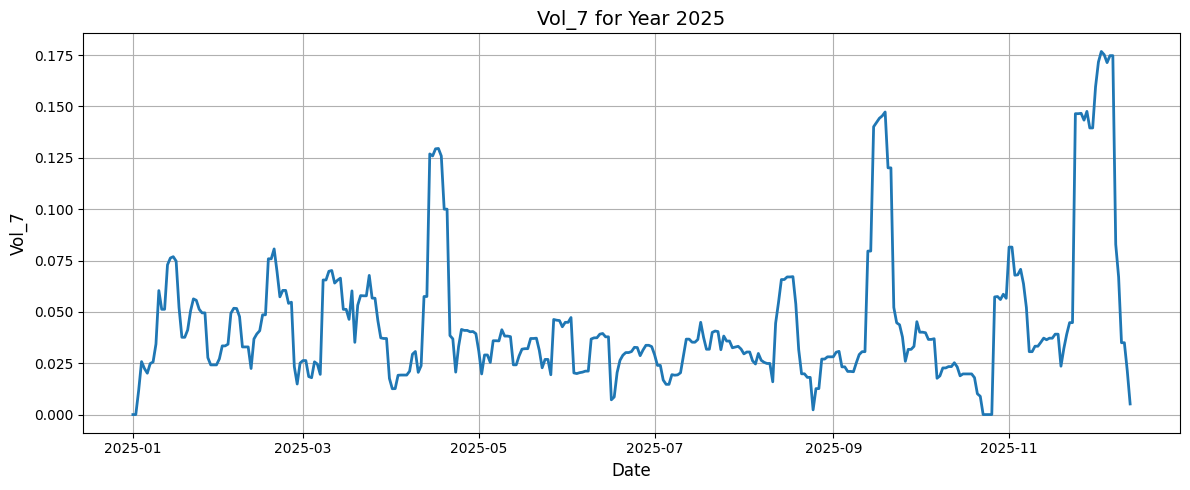

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(eval_df['Arrival_Date'], eval_df['vol_7'], linewidth=2)
plt.title("Vol_7 for Year 2025", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Vol_7", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

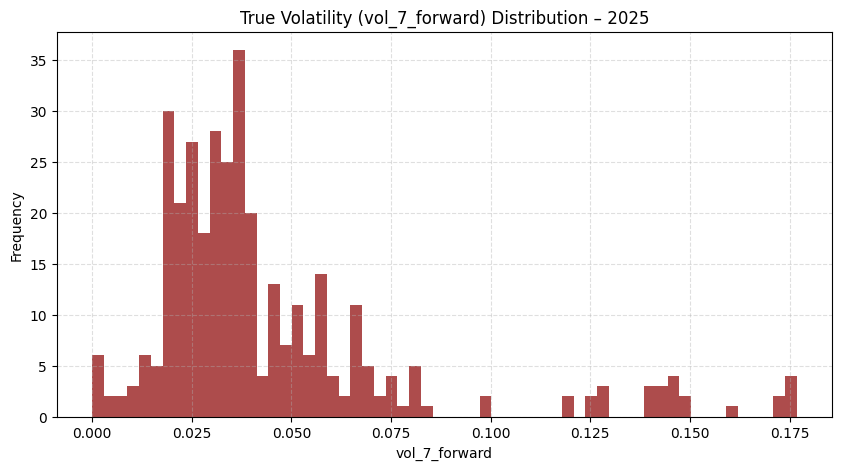

In [108]:
plt.figure(figsize=(10,5))
plt.hist(eval_df['vol_7_next'], bins=60, alpha=0.7, color='darkred')
plt.title("True Volatility (vol_7_forward) Distribution – 2025")
plt.xlabel("vol_7_forward")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


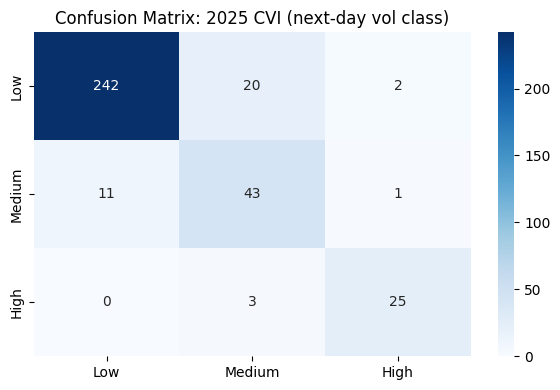

In [109]:
cm_df=pd.DataFrame(cm, index=['Low','Medium','High'], columns=['Low','Medium','High'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: 2025 CVI (next-day vol class)")
plt.tight_layout()
plt.show()

In [110]:
eval_df.to_csv("preds_2025_with_truth.csv",index=False)
print("Success")

Success


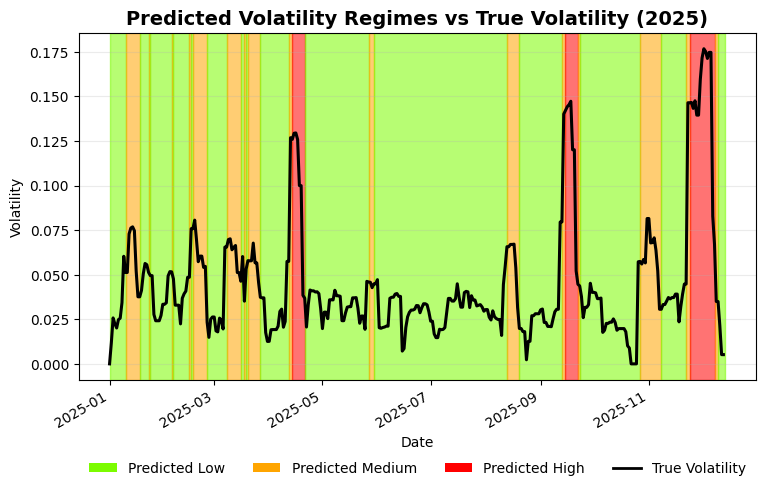

In [111]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd


df = eval_df.copy()
df = df.sort_values("date").reset_index(drop=True)


pred_color = {
    "Low": "#7cfc00",
    "Medium": "#ffa500",
    "High": "#ff0000"
}


df['grp'] = (df['cvi_label'] != df['cvi_label'].shift(1)).cumsum()
spans = df.groupby('grp').agg(
    start=('date','first'),
    end=('date','last'),
    label=('cvi_label','first')
).reset_index(drop=True)


fig, ax = plt.subplots(figsize=(8,5))


for _, r in spans.iterrows():
    ax.axvspan(
        r['start'],
        r['end'] + pd.Timedelta(days=1),
        color=pred_color.get(r['label'], "#f3f4f6"),
        alpha=0.55
    )


ax.plot(df['date'], df['vol_7_next'], color='black', linewidth=2.2, label="True Volatility")



patches = [
    mpatches.Patch(facecolor=pred_color['Low'], label='Predicted Low'),
    mpatches.Patch(facecolor=pred_color['Medium'], label='Predicted Medium'),
    mpatches.Patch(facecolor=pred_color['High'], label='Predicted High')
]


ax.legend(
    handles=patches + [
        plt.Line2D([0],[0], color="black", lw=2, label="True Volatility"),

    ],
    loc="upper center",
    frameon=False,
    fontsize=10,
    ncol=4,
    bbox_to_anchor=(0.5, -0.20)

)


ax.set_title("Predicted Volatility Regimes vs True Volatility (2025)", fontsize=14, weight="600")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")


ax.grid(axis='y', alpha=0.25)
fig.autofmt_xdate(rotation=30)


plt.tight_layout()
plt.show()



In [112]:
df_2025=pd.read_csv("/content/preds_2025_with_truth.csv")
df_train_final=pd.read_csv("/content/2013_2024_predictions.csv")

In [113]:
df_2025=df_2025.drop(columns=["date"])

In [114]:
df_2025["Arrival_Date"]=pd.to_datetime(df_2025["Arrival_Date"])
df_train_final["Arrival_Date"]=pd.to_datetime(df_train_final["Arrival_Date"])

/tmp/ipython-input-1750057320.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_train_final["Arrival_Date"]=pd.to_datetime(df_train_final["Arrival_Date"])


In [115]:
use_cols=["Arrival_Date","Modal_Price","vol_7","vol_7_next","vol_class_global","cvi_label","price_movement"]
df_2025=df_2025[use_cols].copy()

In [116]:
df_master=pd.concat([df_train_final,df_2025], ignore_index=True)

In [117]:
df_master=df_master.sort_values("Arrival_Date")

In [118]:
df_master["Arrival_Date"].max()

Timestamp('2025-12-13 00:00:00')

In [119]:
df_master.to_csv("2013_2025_predictions.csv",index=False)